In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seysmo.models.model_class import CNN, CNNLSTMNetwork, CNNLSTMNetwork2, MLP, ParallelLSTMConv2DModel, LSTMPredictor
from seysmo.models.train_model import train, evaluate
from seysmo.models.utils import save_model, load_model, count_parameters, EarlyStopper, SignalSpeedDataset, give_data
from seysmo.visualization.plotting import plot_map
from seysmo.features.mapping import do_array_for_mapping, compute_y_pred
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchinfo import summary
from torchmetrics import MeanAbsolutePercentageError

import mlflow

mlflow.set_tracking_uri("http://localhost:5000")

In [2]:
X_train, y_train, coord_train, X_val, y_val, coord_val, X_test, y_test, coord_test = give_data(
    '../data/processed/coord_dict.pkl', 3)

In [3]:
X_train.shape

(11045, 33, 438)

In [8]:
X_train = np.transpose(X_train, (0,2,1))
X_val = np.transpose(X_val, (0,2,1))
X_test = np.transpose(X_test, (0,2,1))
X_train.shape

(11045, 438, 33)

In [9]:
train_dataset = SignalSpeedDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = SignalSpeedDataset(X_val, y_val)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = SignalSpeedDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
in_channels = 1
out_channels = 16
conv_kernel_size = 4
pool_kernel_size = 2
stride = 2
padding = 1
input_size = 33
hidden_size = 64
num_layers = 32
dropout = 0.2
linear_input_size = 64
linear_output_size = 10
input_shape = X_train[0].shape
epochs = 250
batch_size = 32
learning_rate = 0.001
patience = 3
min_delta = 30
loss_fn = nn.MSELoss()
metric_fn = MeanAbsolutePercentageError().to(device)
model0 = ParallelLSTMConv2DModel(lstm_input_size=input_size, lstm_hidden_size=hidden_size, lstm_num_layers=num_layers, dropout=dropout, conv_in_channels=in_channels, conv_out_channels=out_channels, conv_kernel_size=conv_kernel_size, stride=stride, padding=padding, pool_kernel_size=pool_kernel_size, fc1_output_size=linear_input_size, fc2_output_size=linear_output_size, input_shape=input_shape).to(device)
early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)
optimizer = torch.optim.Adam(model0.parameters(), lr=learning_rate)

In [7]:
mlflow.set_experiment("/Parralel_v0.1")

<Experiment: artifact_location='mlflow-artifacts:/431363399785369768', creation_time=1722174060954, experiment_id='431363399785369768', last_update_time=1722174060954, lifecycle_stage='active', name='/Parralel_v0.1', tags={}>

In [8]:
with mlflow.start_run(run_name='first_depth') as run:
    params = {
        "epochs": epochs,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "loss_function": loss_fn.__class__.__name__,
        "metric_function": metric_fn.__class__.__name__,
        "optimizer": "ADAM",
        "in_channels": in_channels,
        'out_channels': out_channels,
        "conv_kernel_size": conv_kernel_size,
        "pool_kernel_size": pool_kernel_size,
        'stride': stride,
        'padding': padding,
        'input_size': input_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
        'linear_input_size': linear_input_size,
        'linear_output_size': linear_output_size,
        "input_shape": input_shape,
        'patience': patience,
        'min_delta': min_delta
    }
    # Log training parameters.
    mlflow.log_params(params)

    # Log model summary.
    with open("../models/model_P_summary.txt", "w", encoding="utf-8") as f:
        f.write(str(summary(model0)))
    mlflow.log_artifact("../models/model_P_summary.txt")

    for t in range(epochs):
        print(f"Epoch {t + 1}\n-------------------------------")
        train(train_dataloader, model0, loss_fn, metric_fn, optimizer, epoch=t, device=device,
              output_size=linear_output_size)
        validation_loss, validation_mape = evaluate(val_dataloader, model0, loss_fn, metric_fn, epoch=t, device=device,
                                                    output_size=linear_output_size)

    # Save the trained model to MLflow.
    mlflow.pytorch.log_model(model0, "model")

Epoch 1
-------------------------------
loss: 127843.929688 MAPE: 1.000073 [0 / 346]
loss: 6098.977539 MAPE: 0.182060 [100 / 346]
loss: 3286.345459 MAPE: 0.126966 [200 / 346]
loss: 1299.149048 MAPE: 0.089830 [300 / 346]
Eval metrics: 
MAPE: 0.10, Avg loss: 1861.836636 

Epoch 2
-------------------------------
loss: 1686.370483 MAPE: 0.087314 [0 / 346]
loss: 1502.827515 MAPE: 0.089230 [100 / 346]
loss: 1871.789429 MAPE: 0.093239 [200 / 346]
loss: 1347.003540 MAPE: 0.075537 [300 / 346]
Eval metrics: 
MAPE: 0.08, Avg loss: 1454.141262 

Epoch 3
-------------------------------
loss: 1568.088867 MAPE: 0.091001 [0 / 346]
loss: 1439.566772 MAPE: 0.079748 [100 / 346]
loss: 1286.935913 MAPE: 0.076458 [200 / 346]
loss: 1242.752686 MAPE: 0.073676 [300 / 346]
Eval metrics: 
MAPE: 0.08, Avg loss: 1376.526491 

Epoch 4
-------------------------------
loss: 1478.810547 MAPE: 0.081038 [0 / 346]
loss: 1532.386597 MAPE: 0.078518 [100 / 346]
loss: 1503.266113 MAPE: 0.084272 [200 / 346]
loss: 1632.552368 

2024/07/28 19:16:34 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Eval metrics: 
MAPE: 0.07, Avg loss: 1110.878939 


2024/07/28 19:16:56 WARNING mlflow.utils.requirements_utils: Found torch version (2.3.1+cu118) contains a local version label (+cu118). MLflow logged a pip requirement for this package as 'torch==2.3.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


In [11]:
model0 = torch.load("C:/Users/vitya/Work/seysmo/mlartifacts/431363399785369768/2e41edfc7191434283e51673afe25b46/artifacts/model/data/model.pth")

In [12]:
model0.to('cuda')

ParallelLSTMConv2DModel(
  (lstm): LSTM(33, 64, num_layers=32, batch_first=True, dropout=0.2)
  (conv): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=14016, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)

In [13]:
num_batches = len(test_dataloader)
eval_loss, eval_mape = 0, 0
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model0(X)
        eval_loss += loss_fn(torch.reshape(pred, (-1, 10)), torch.reshape(y, (-1, 10))).item()
        eval_mape += metric_fn(torch.reshape(pred, (-1, 10)), torch.reshape(y, (-1, 10))).item()

eval_loss /= num_batches
eval_mape /= num_batches
print(f"Test loss: {eval_loss:4f}")
print(f"Test MAPE: {eval_mape:4f}")

Test loss: 1102.476719
Test MAPE: 0.066797


C:\Users\vitya\Work\seysmo\seysmo\visualization\plotting.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


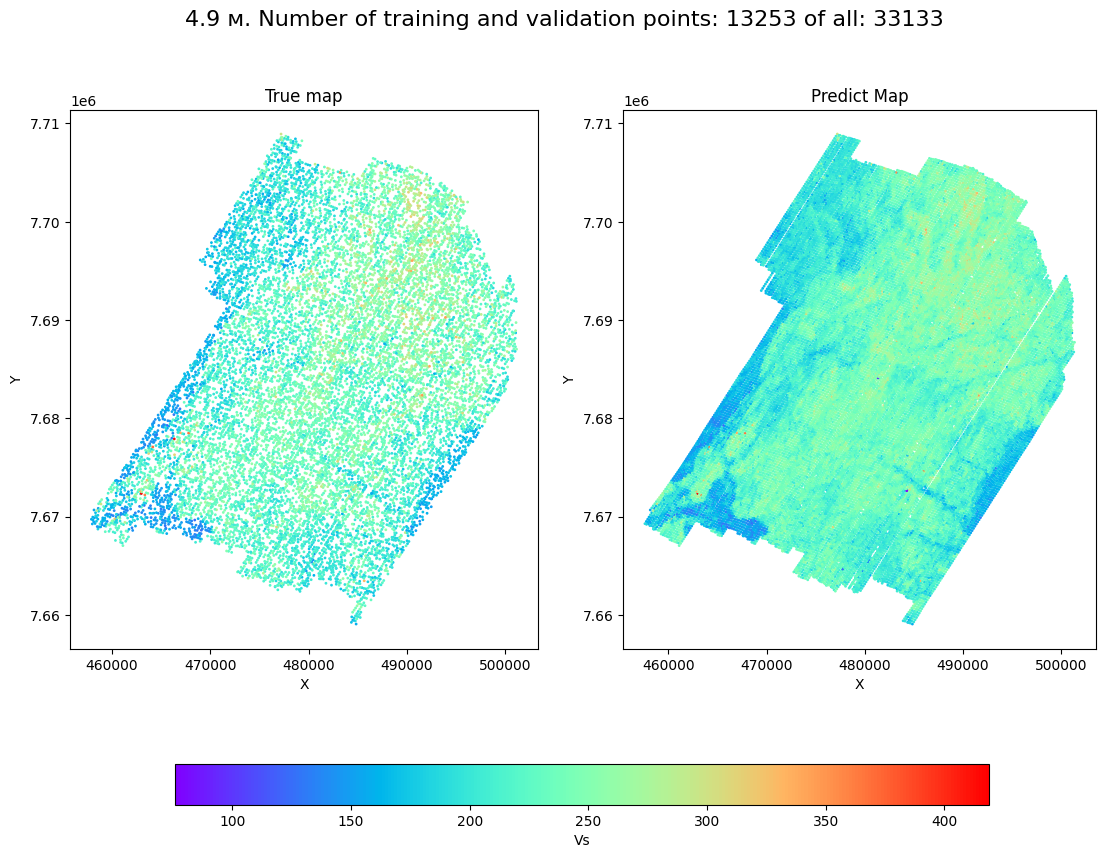

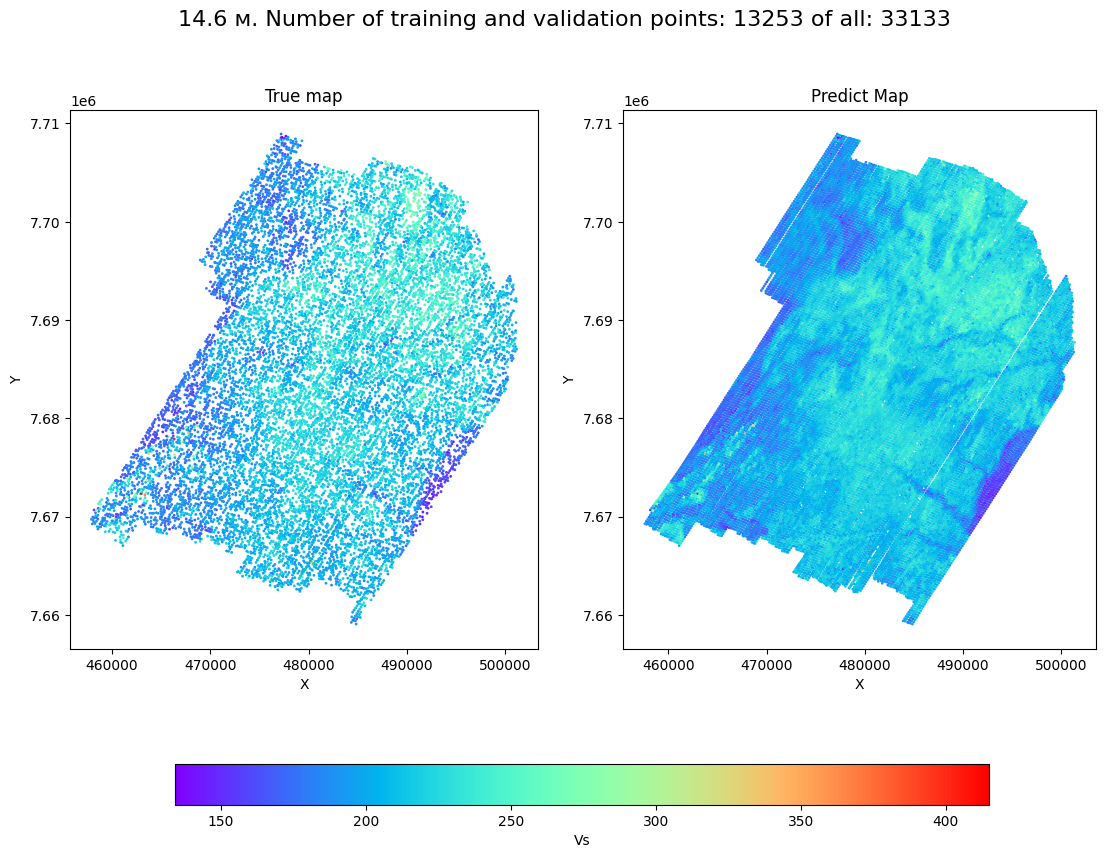

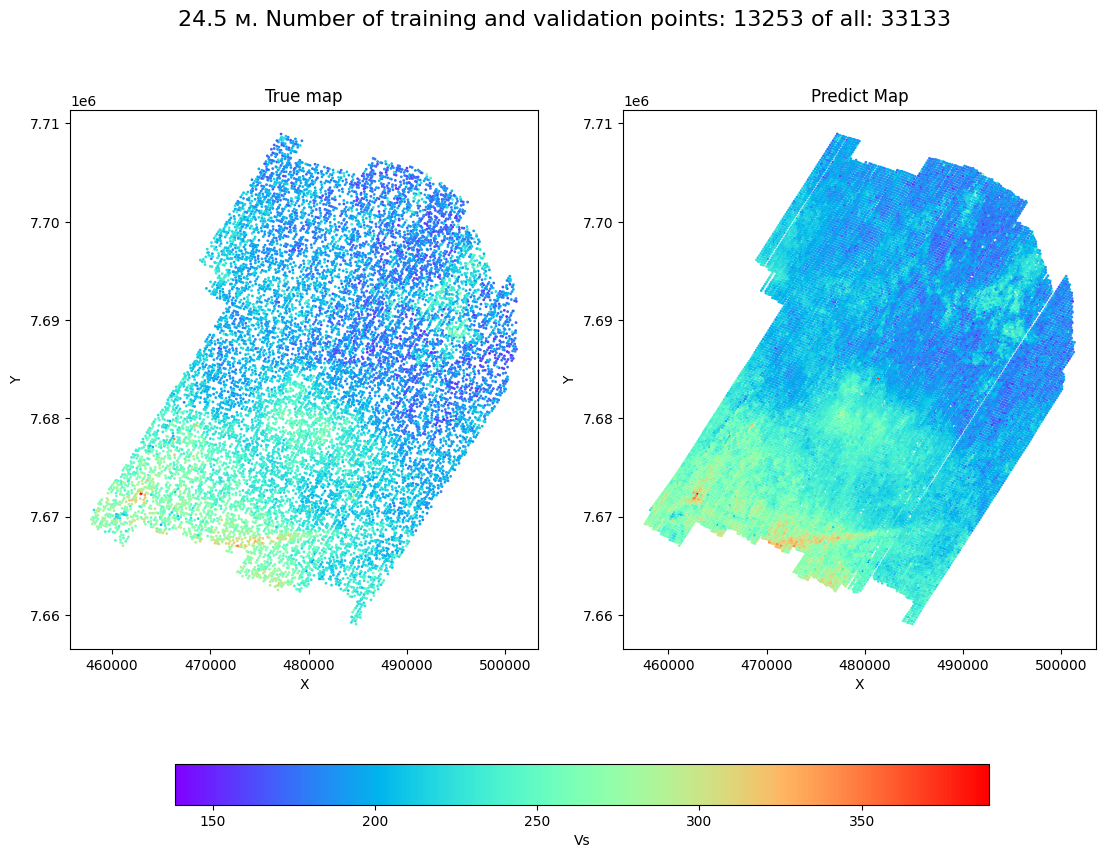

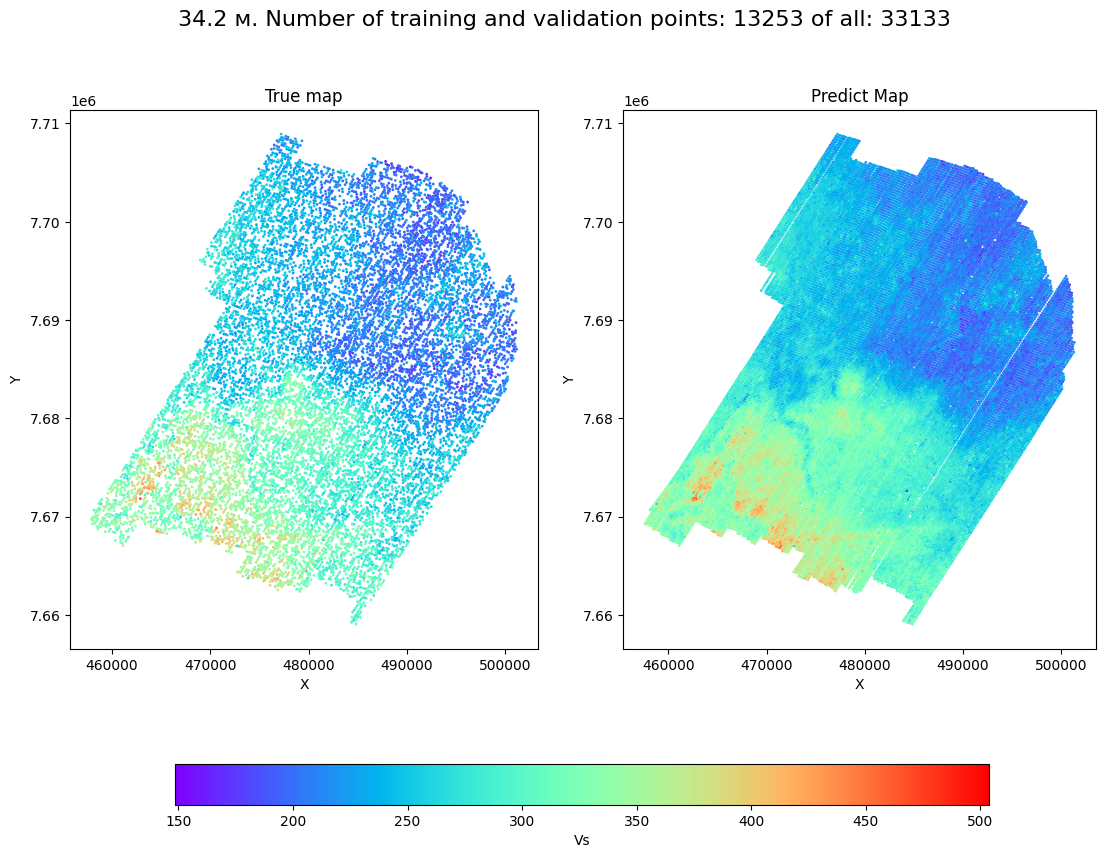

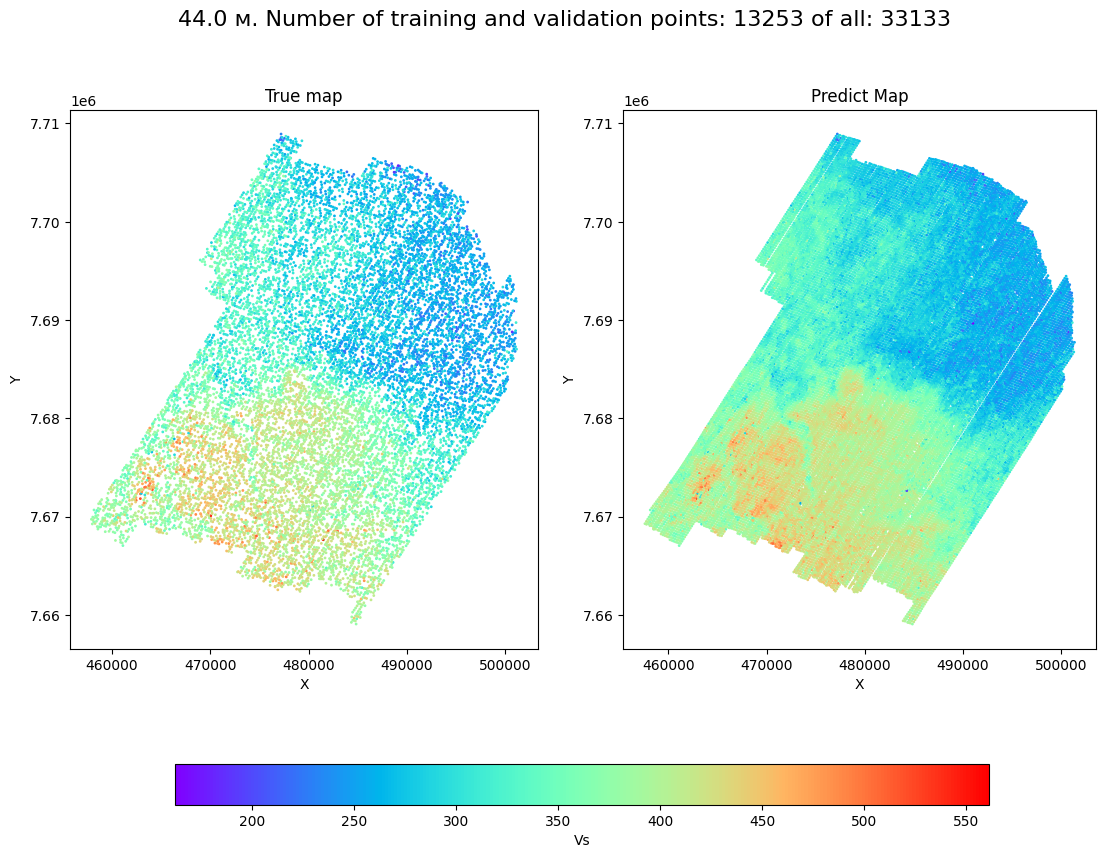

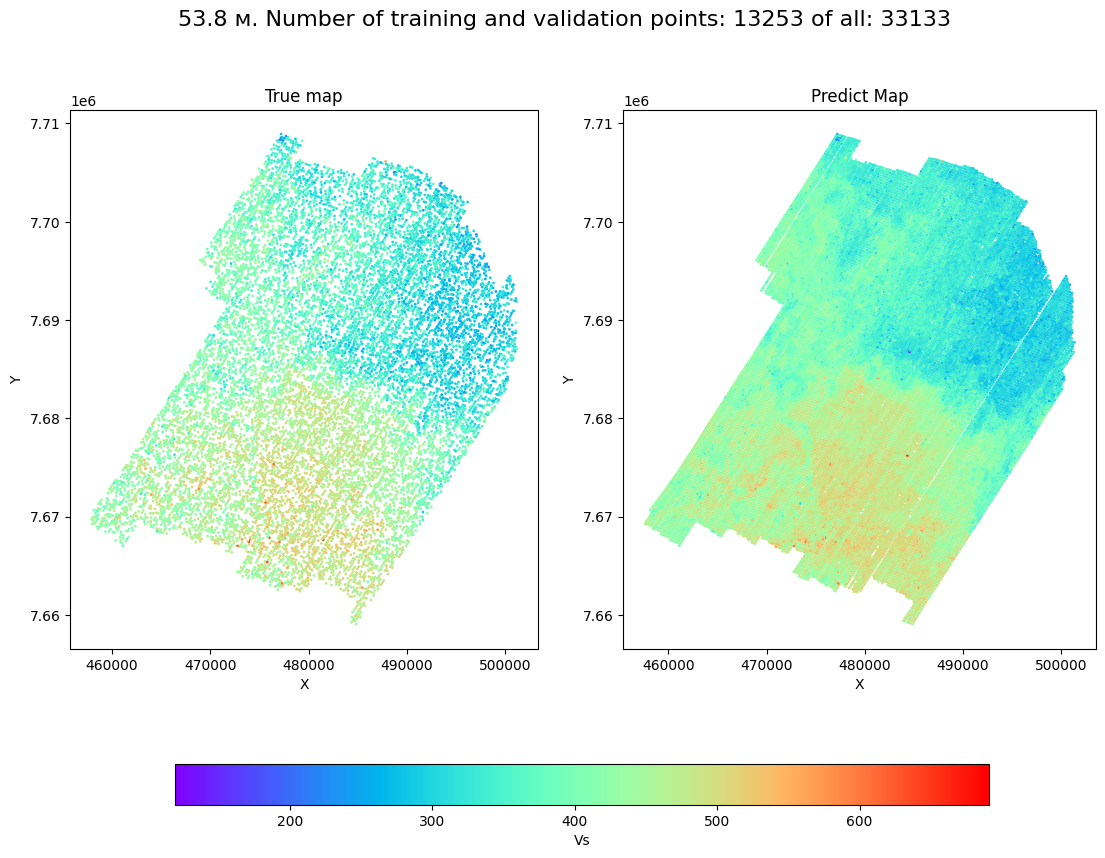

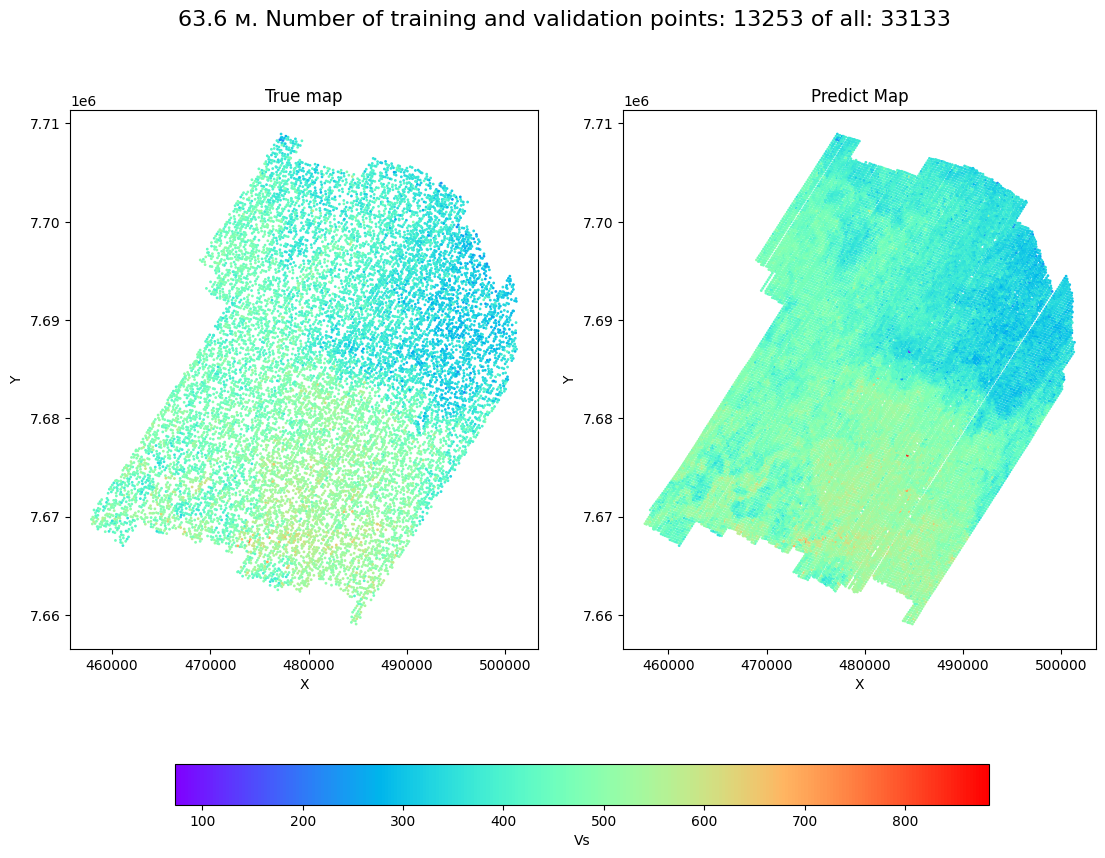

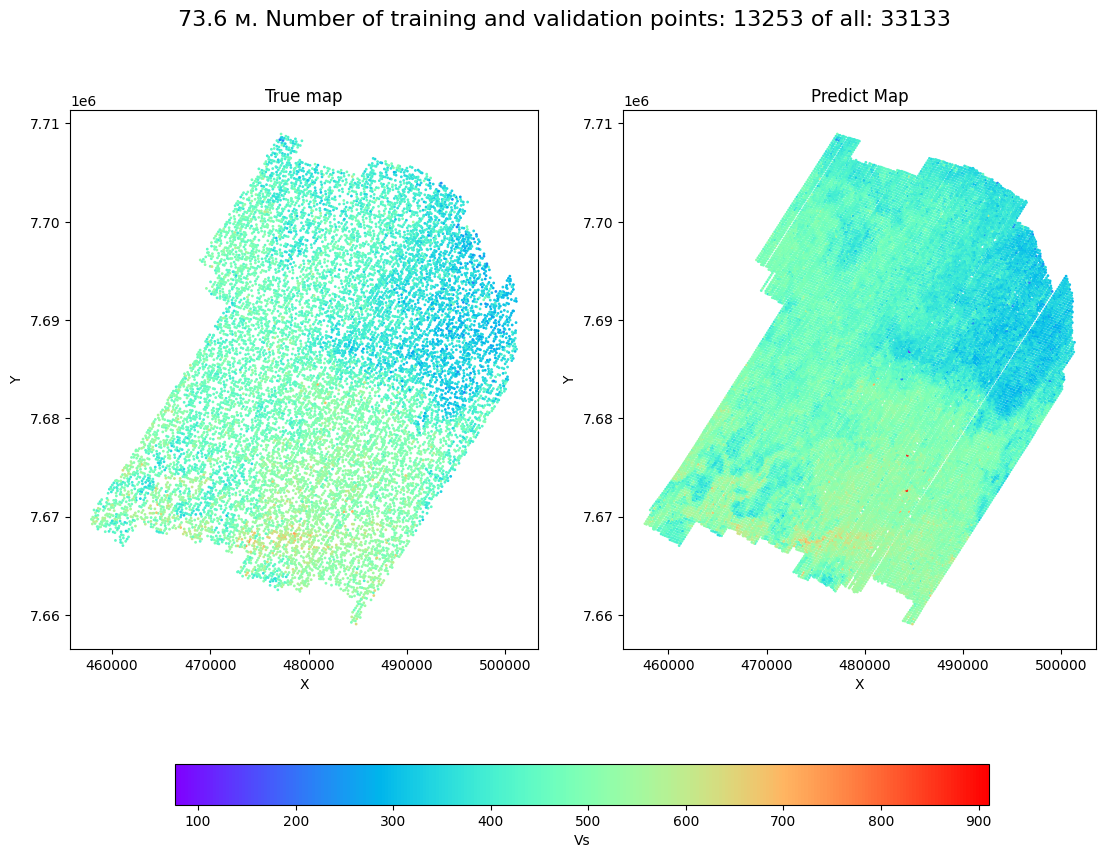

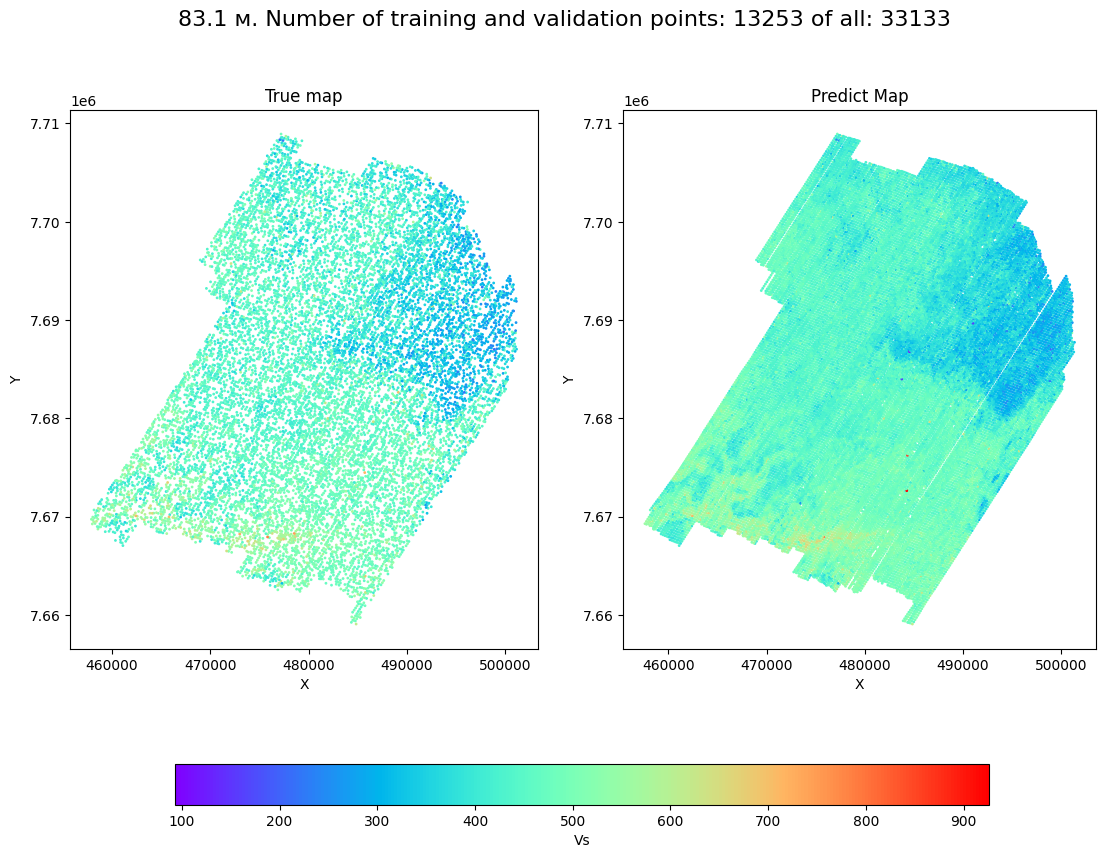

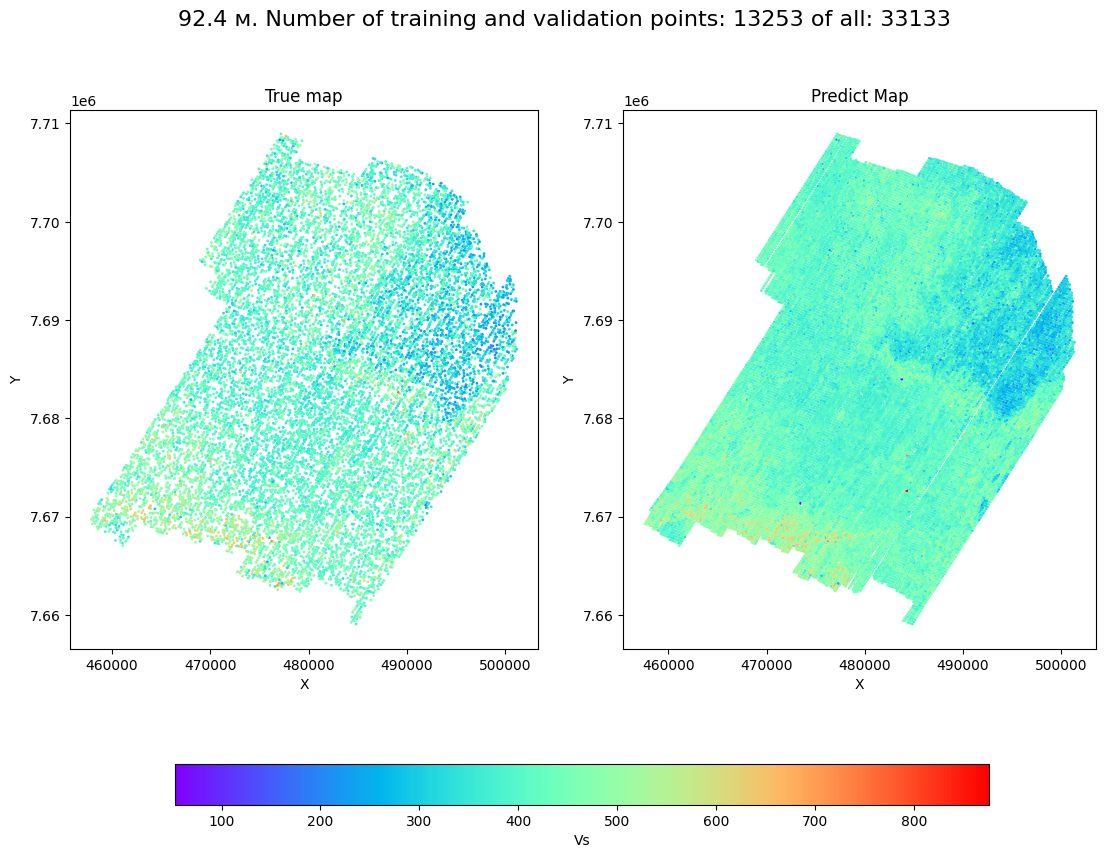

In [14]:
y_pred = None
with torch.no_grad():
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        pred = model0(X).to("cpu").detach().numpy()
        if y_pred is None:
            y_pred = pred
        else:
            y_pred = np.concatenate([y_pred, pred])
depth_ar = [4.9, 14.6, 24.5, 34.2, 44.0, 53.8, 63.6, 73.6, 83.1, 92.4]
for i in range(10):
    true_slice = do_array_for_mapping(coord_train, coord_val, y_train[:, i], y_val[:, i])
    pred_slice = do_array_for_mapping(coord_train, coord_val, y_train[:, i], y_val[:, i], coord_test=coord_test, y_test = y_pred[:, i])
    our_map = plot_map(true_slice, pred_slice, depth_ar[i], X_train.shape[0], X_val.shape[0], X_test.shape[0])
    our_map.savefig(f"../reports/figures/maps/{round(depth_ar[i])}minimap.png")
    plt.show(our_map)